In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from skimage.filters import threshold_multiotsu

from preprocessing import ZeissImageProcessor
import cv2

In [2]:
def get_mesh_nodes(image, ratio=1):
    # Blur
    blurred = cv2.GaussianBlur(image, (7, 7), 0)
    # Multi-Otsu
    thresholds = threshold_multiotsu(blurred, classes=3)
    t_high = thresholds[1]

    t_high *= ratio 
    
    _, thresh = cv2.threshold(blurred, t_high, 255, cv2.THRESH_BINARY)
    
    # Morfologia
    thresholded = cv2.morphologyEx(
        thresh, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8)
    )
    # Connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresholded)
    return centroids

In [7]:
def visualize_results(ZIP_object):


    plt.imshow(ZIP_object.image_to_analyze)
    

    meas_points = ZIP_object.not_scaled_points
    

    for point_type in meas_points.keys():
       
        points = meas_points[point_type]

        plt.scatter(points[:, 0], points[:, 1], s=5, label=point_type)
    
    
    plt.legend()
    plt.title('Points for measurement')

In [8]:
main_path = '01092025-onchip-3rd'
files = [f for f in os.listdir(main_path) if f.lower().endswith('.czi')]
directions = [os.path.join(main_path, file_path) for file_path in files]   

In [9]:
directions

['01092025-onchip-3rd\\Image 1.czi',
 '01092025-onchip-3rd\\Image 2.czi',
 '01092025-onchip-3rd\\Image 21.czi',
 '01092025-onchip-3rd\\Image 22.czi',
 '01092025-onchip-3rd\\Image 23.czi',
 '01092025-onchip-3rd\\Image 24.czi',
 '01092025-onchip-3rd\\Image 25.czi',
 '01092025-onchip-3rd\\Image 4.czi',
 '01092025-onchip-3rd\\Image 5.czi',
 '01092025-onchip-3rd\\Image 6.czi']

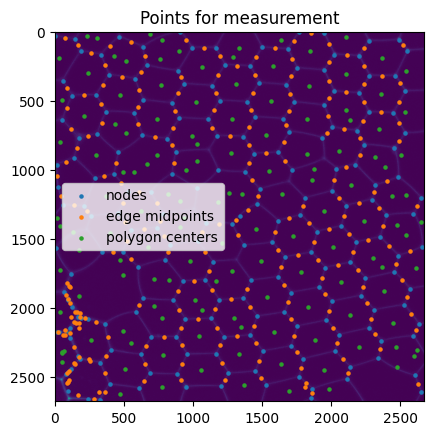

In [10]:
obj1 = ZeissImageProcessor(directions[0])
visualize_results(obj1)

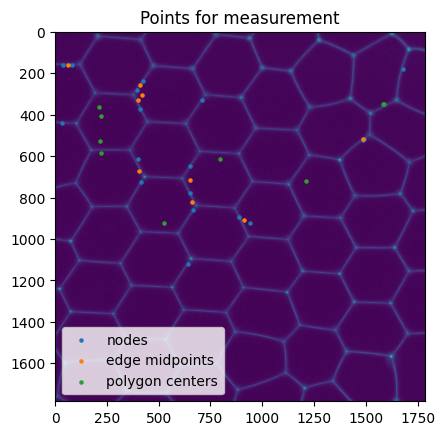

In [11]:
obj2 = ZeissImageProcessor(directions[1])
visualize_results(obj2)

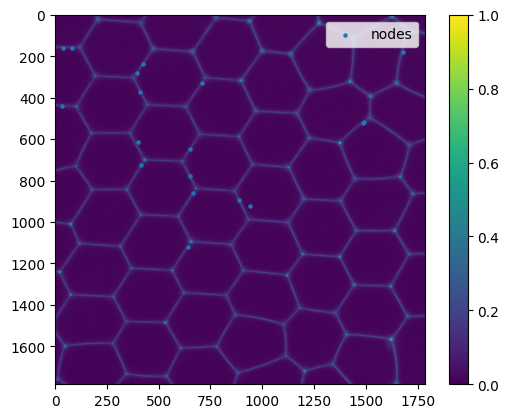

In [12]:
img2 = obj2.image_to_analyze
plt.imshow(img2)

nds2 = get_mesh_nodes(img2, ratio=1.09)

plt.scatter(nds2[:, 0], nds2[:, 1], s=5, label='nodes')

plt.legend()
plt.colorbar()

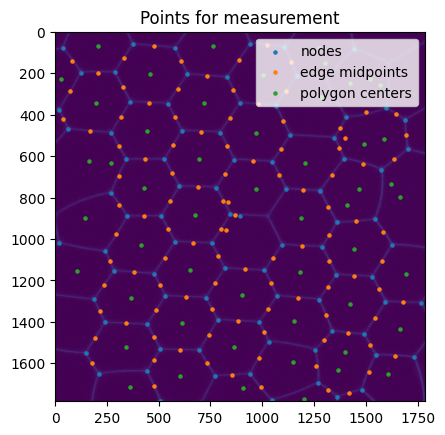

In [13]:
obj3 = ZeissImageProcessor(directions[7])
visualize_results(obj3)

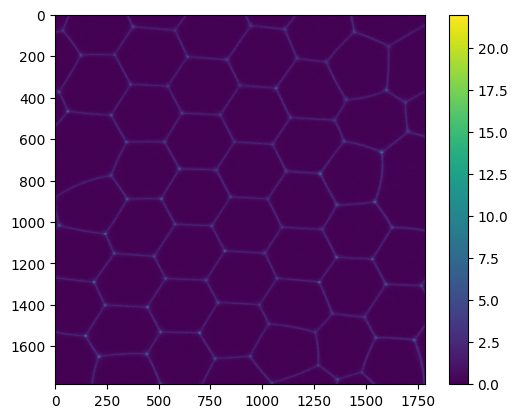

In [14]:
plt.imshow(obj3.image_to_analyze)
plt.colorbar()

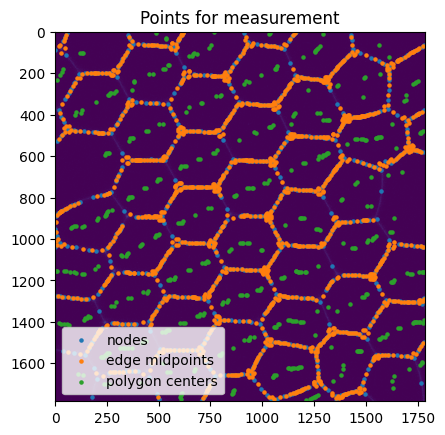

In [15]:
obj4 = ZeissImageProcessor(directions[8], analysis_channel=1)
visualize_results(obj4)

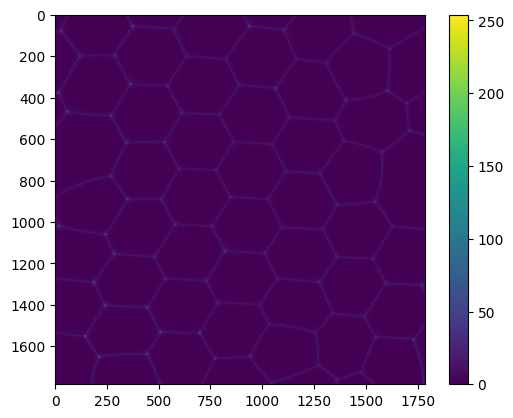

In [16]:
plt.imshow(obj4.image_to_analyze)
plt.colorbar()

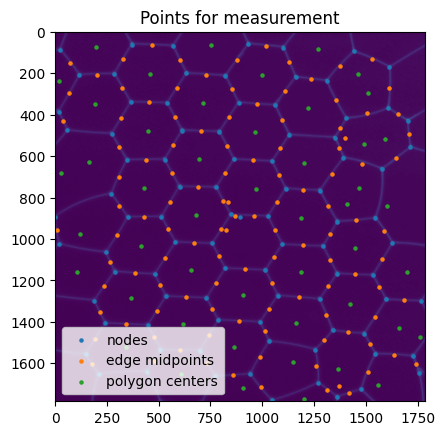

In [17]:
obj5 = ZeissImageProcessor(directions[9])
visualize_results(obj5)

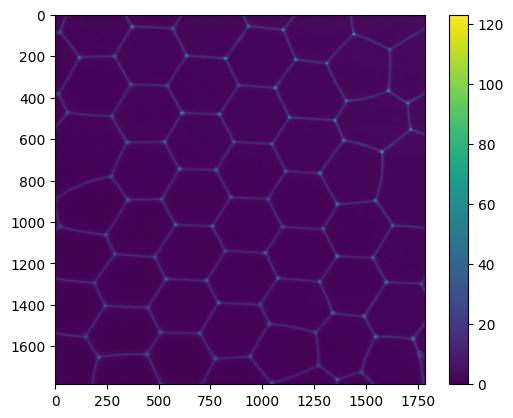

In [18]:
plt.imshow(obj5.image_to_analyze)
plt.colorbar()

# Testing the GUVs

In [12]:
main_path = 'GUVs_Laura/'
files = [f for f in os.listdir(main_path) if f.lower().endswith('.czi')]
directions = [os.path.join(main_path, file_path) for file_path in files]   

In [13]:
directions

['GUVs_Laura/Snap-10242.czi',
 'GUVs_Laura/Snap-10243.czi',
 'GUVs_Laura/Snap-10245.czi',
 'GUVs_Laura/Snap-10457.czi',
 'GUVs_Laura/Snap-10458.czi',
 'GUVs_Laura/Snap-10459.czi',
 'GUVs_Laura/Snap-10460.czi']

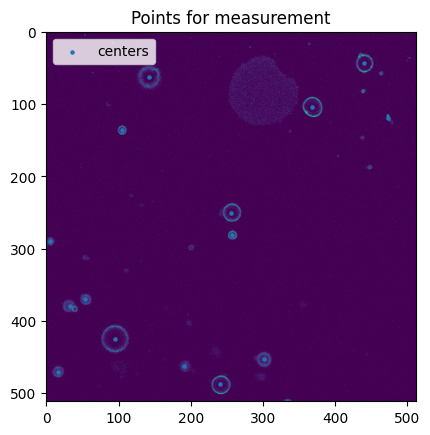

In [14]:
obj1 = ZeissImageProcessor(directions[1], analysis_channel=0, chosen_analysis='GUVs')

visualize_results(obj1)

In [67]:
def _classify_contours_by_area(contours, hierarchy, top_n=None):
    """
    Finds external contours and their internal contours, sorted by area in descending order.
    Args:
        contours (list): List of contours.
        hierarchy (numpy.ndarray): Contour hierarchy information.
        top_n (int, optional): Number of top external contours to return. If None, returns all.
    Returns:
        list: Tuples of (external_contour, internal_contours_list) sorted by external contour area.
    """
    # Map parent indices to their child contours
    parent_children_map = defaultdict(list)
    external_contours = []
    # Identify external contours and collect their largest internal
    for i in range(len(contours)):
        if hierarchy[0][i][3] == -1:  # External contour has no parent
            ext_contour = contours[i]
            area = cv2.contourArea(ext_contour)
            internal_contours = parent_children_map.get(i, [])
            # Find the largest internal contour if any
            largest_internal = None
            if internal_contours:
                largest_internal = max(internal_contours, key=lambda c: cv2.contourArea(c))
            external_contours.append((area, ext_contour, largest_internal))
    # Sort by external contour area (descending)
    external_contours.sort(reverse=True, key=lambda x: x[0])
    # Apply top_n limit
    if top_n is not None:
        external_contours = external_contours[:top_n]
    # Return tuples (external_contour, largest_internal_contour)
    return [(ext, largest_internal) for (_, ext, largest_internal) in external_contours]
def _create_mask(contours, image_shape):
    masks = []
    for contour in contours:
        mask = np.zeros(image_shape, dtype=np.uint8)
        if contour is not None:
            cv2.drawContours(mask, [contour], -1, 255, cv2.FILLED)
        masks.append(mask)
        # print(len(masks))
    return masks

def get_contour_centers_and_radii(contours):
    """
    Returns a dictionary mapping contour indices to dicts {center: (cx, cy), radius: r}
    """
    results = {}
    for idx, cnt in enumerate(contours):
        M = cv2.moments(cnt)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
        # else:
        #     cx, cy = None, None  # brak centrum dla konturów o zerowej powierzchni
            (x, y), radius = cv2.minEnclosingCircle(cnt)
            
        results[idx] = {"center": (cx, cy), "radius": int(radius)}
    return results

In [72]:
from collections import defaultdict


blurred = blurred = cv2.GaussianBlur(arr, (5,5), 0)

#blurred = blurred = cv2.medianBlur(arr, 5)

otsu_threshold, thresholded = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

found_contours, hierarchy = cv2.findContours(np.array(thresholded, dtype=np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

classified = _classify_contours_by_area(found_contours, hierarchy)

external_contours = [ext_contour for (ext_contour, _) in classified]

masks = _create_mask(external_contours, arr.shape)

mean_radius = get_contour_centers_and_radii(external_contours)

In [73]:
mean_radius

{0: {'center': (264, 231), 'radius': 63},
 1: {'center': (411, 463), 'radius': 31}}

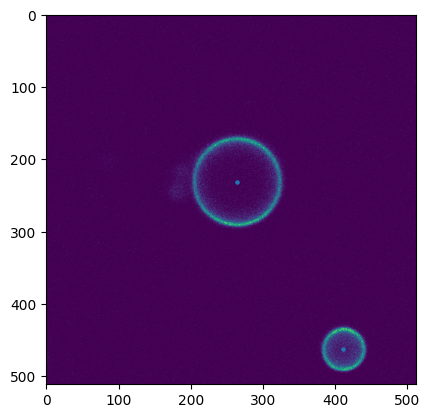

In [74]:
plt.imshow(obj1.image_to_analyze)

points = np.array([v['center'] for v in mean_radius.values()])[0:15]

plt.scatter(points[:, 0], points[:, 1], s=5, label="middle")
#plt.legend()

In [75]:
obj1.metadata

{'scaling_um_per_pixel': {'X': 1.2478515625e-07, 'Y': 1.2478515625e-07},
 'channels': [{'id': None,
   'name': '',
   'emission_nm': None,
   'excitation_nm': None},
  {'id': None, 'name': 'ATTO 655', 'emission_nm': None, 'excitation_nm': None},
  {'id': None, 'name': '', 'emission_nm': None, 'excitation_nm': None},
  {'id': None, 'name': 'Cy3', 'emission_nm': None, 'excitation_nm': None},
  {'id': None, 'name': '', 'emission_nm': None, 'excitation_nm': None},
  {'id': None, 'name': '', 'emission_nm': None, 'excitation_nm': None},
  {'id': None, 'name': 'ATTO 488', 'emission_nm': None, 'excitation_nm': None},
  {'id': None, 'name': '', 'emission_nm': None, 'excitation_nm': None},
  {'id': None, 'name': '', 'emission_nm': None, 'excitation_nm': None},
  {'id': 'Channel:0',
   'name': None,
   'emission_nm': 683.0,
   'excitation_nm': 663.0},
  {'id': 'Channel:1',
   'name': None,
   'emission_nm': None,
   'excitation_nm': None},
  {'id': 'Channel:2',
   'name': None,
   'emission_nm': 